In [1]:
using DifferentialEquations
using Plots
using Statistics
using DataFrames, GLM

In [2]:
dts = [0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625]

8-element Array{Float64,1}:
 0.5
 0.25
 0.125
 0.0625
 0.03125
 0.015625
 0.0078125
 0.00390625

## First we check Ito

In [3]:
# u₀=1.
# f(u,p,t) = - sin(u) * cos(u)^3
# g(u,p,t) = cos(u)^2
# f_analytic(u₀,p,t,W) = atan(W + tan(u₀)) <-- I couldn't find what solution would be with .1 *g
# ff = SDEFunction(f,g,analytic=f_analytic)
# prob = SDEProblem(ff,g,u₀,(0.0,5.0))

In [16]:
u₀=1.
sigma = 1.
mu = .1 * (-sigma ^ 2 - 1.)
f(u,p,t) = mu * u
g(u,p,t) = sigma * u
f_analytic(u₀,p,t,W) = u₀ * exp((mu - sigma ^ 2. / 2.) * t + sigma * W)
ff = SDEFunction(f,g,analytic=f_analytic)
prob = SDEProblem(ff,g,u₀,(0.0,5.0))

SDEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 5.0)
u0: 1.0

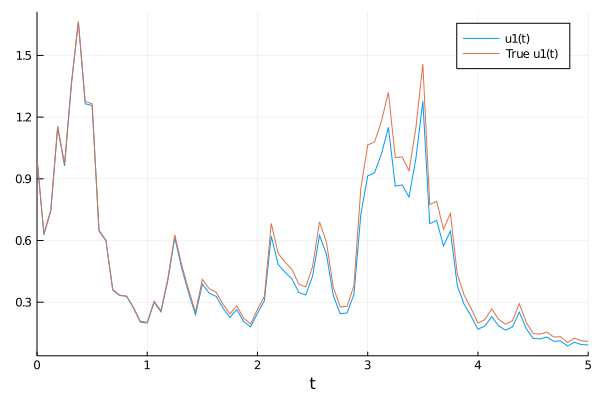

In [17]:
sol = solve(prob,RKMil(),dt=0.0625,adaptive=false)
plot(sol,plot_analytic=true)

In [18]:
result = []
for i in dts
    sol = solve(prob,RKMil(),dt=i,adaptive=false)
    m = mean((sol.u_analytic - sol.u).^2)
    append!(result, m)
end

log_dts = log.(dts)
log_result = log.(result) / 2

8-element Array{Float64,1}:
 -2.20633496897094
 -2.4450683285597816
 -3.4843320090037753
 -4.1476964652345725
 -6.093149739147844
 -4.275706733892642
 -5.702328868991033
 -7.79493585099499

In [19]:
data = DataFrame(X=log_dts, Y=log_result)

,X,Y
,Float64,Float64
1,-0.693147,-2.20633
2,-1.38629,-2.44507
3,-2.07944,-3.48433
4,-2.77259,-4.1477
5,-3.46574,-6.09315
6,-4.15888,-4.27571
7,-4.85203,-5.70233
8,-5.54518,-7.79494


In [20]:
ols = lm(@formula(Y ~ X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  -1.31908    0.659161  -2.00    0.0923   -2.93199   0.293826
X             1.02579    0.18832    5.45    0.0016    0.56499   1.48659
────────────────────────────────────────────────────────────────────────

## Now we check Stratonovich

In [9]:
# correction
f(u,p,t) = mu * u - .5 * sigma ^ 2 * u

f (generic function with 1 method)

In [10]:
ff = SDEFunction(f,g,analytic=f_analytic)
prob = SDEProblem(ff,g,u₀,(0.0,5.0))

SDEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 5.0)
u0: 1.0

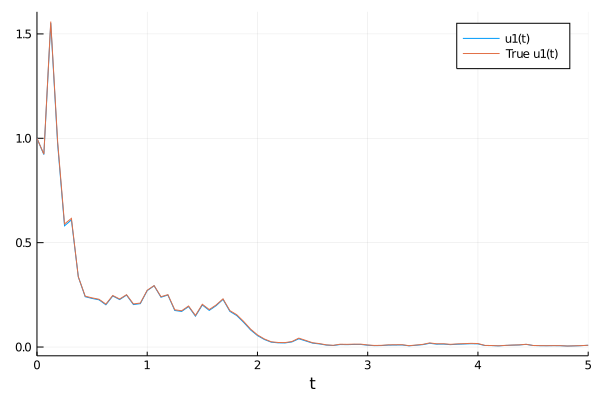

In [11]:
sol = solve(prob,RKMil(interpretation=:Stratonovich),dt=0.0625,adaptive=false)
plot(sol,plot_analytic=true)

In [12]:
result = []
for i in dts
    sol = solve(prob,RKMil(interpretation=:Stratonovich),dt=i,adaptive=false)
    m = mean((sol.u_analytic - sol.u).^2)
    append!(result, m)
end

log_dts = log.(dts)
log_result = log.(result) / 2

8-element Array{Float64,1}:
 -2.8000698169271354
 -3.092460622075263
 -4.865473053683952
 -5.778309888356563
 -3.263426764840607
 -6.215353598918056
 -7.420929748218476
 -8.931766814934248

In [13]:
data = DataFrame(X=log_dts, Y=log_result)

,X,Y
,Float64,Float64
1,-0.693147,-2.80007
2,-1.38629,-3.09246
3,-2.07944,-4.86547
4,-2.77259,-5.77831
5,-3.46574,-3.26343
6,-4.15888,-6.21535
7,-4.85203,-7.42093
8,-5.54518,-8.93177


In [14]:
ols = lm(@formula(Y ~ X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y ~ 1 + X

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  -1.75496    0.91133   -1.93    0.1025  -3.9849     0.474988
X             1.13525    0.260364   4.36    0.0048   0.498159   1.77233
────────────────────────────────────────────────────────────────────────